# MNIST Digit Addition Problem

This is an adaptation of the experiment on Single Digit Addition, on a more complicated setup with multiple digits.

Consider the classifier $\mathtt{addition([X_1,X_2],[Y_1,Y_2],N)}$. $\mathtt{[X_1,X_2]}$ and $\mathtt{[Y_1,Y_2]}$ are lists of images of digits, representing two multi-digit numbers; $\mathtt{N}$ is a natural number corresponding to the sum of the two multi-digit numbers. The classifier must return a confidence in the validity of the addition.

The steps are similar to that of the Single Digit Addition example (read the first notebook for more details).

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import logictensornetworks as ltn
import baselines, data, commons
import matplotlib.pyplot as plt

Dataset of images for the digits X1, X2, Y1 and Y2, and their label Z s.t. 10\*X1+X2+10\*X2+Y2=Z.

Result label is 126


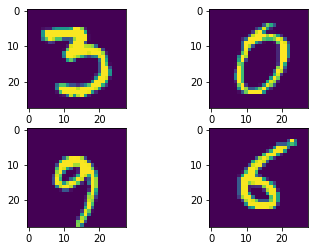

In [2]:
ds_train, ds_test = data.get_mnist_op_dataset(
        count_train=3000,
        count_test=1000,
        buffer_size=3000,
        batch_size=16,
        n_operands=4,
        op=lambda args: 10*args[0]+args[1]+10*args[2]+args[3])

# Visualize one example
x1, x2, y1, y2, z = next(ds_train.as_numpy_iterator())
plt.subplot(221)
plt.imshow(x1[0][:,:,0])
plt.subplot(222)
plt.imshow(x2[0][:,:,0])
plt.subplot(223)
plt.imshow(y1[0][:,:,0])
plt.subplot(224)
plt.imshow(y2[0][:,:,0])
print("Result label is %i" % z[0])

LTN Model and Loss

In [3]:
### Predicates
logits_model = baselines.SingleDigit()
Digit = ltn.Predicate(ltn.utils.LogitsToPredicateModel(logits_model))
### Variables
d1 = ltn.variable("digits1", range(10))
d2 = ltn.variable("digits2", range(10))
d3 = ltn.variable("digits3", range(10))
d4 = ltn.variable("digits4", range(10))
### Operators
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(),semantics="forall")
Exists = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMean(),semantics="exists")

In [4]:
@tf.function
def axioms(images_x1,images_x2,images_y1,images_y2,labels_z,p_schedule):
    images_x1 = ltn.variable("x1", images_x1)
    images_x2 = ltn.variable("x2", images_x2)
    images_y1 = ltn.variable("y1", images_y1)
    images_y2 = ltn.variable("y2", images_y2)
    labels_z = ltn.variable("z", labels_z)
    return Forall(
            ltn.diag(images_x1,images_x2,images_y1,images_y2,labels_z),
            Exists(
                (d1,d2,d3,d4),
                And(
                    And(Digit([images_x1,d1]),Digit([images_x2,d2])),
                    And(Digit([images_y1,d3]),Digit([images_y2,d4]))
                ),
                mask_vars=[d1,d2,d3,d4,labels_z],
                mask_fn=lambda vars: tf.equal(10*vars[0]+vars[1]+10*vars[2]+vars[3],vars[4]),
                p=p_schedule
            ),
            p=2
        )

x1, x2, y1, y2, z = next(ds_train.as_numpy_iterator())
axioms(x1, x2, y1, y2, z, tf.constant(2.))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0002105236>

Optimizer, training steps and metrics

In [5]:
optimizer = tf.keras.optimizers.Adam(0.001)
metrics_dict = {
    'train_loss': tf.keras.metrics.Mean(name="train_loss"),
    'train_accuracy': tf.keras.metrics.Mean(name="train_accuracy"),
    'test_loss': tf.keras.metrics.Mean(name="test_loss"),
    'test_accuracy': tf.keras.metrics.Mean(name="test_accuracy")    
}

@tf.function
def train_step(images_x1,images_x2,images_y1,images_y2,labels_z,**kwargs):
    # loss
    with tf.GradientTape() as tape:
        loss = 1.- axioms(images_x1,images_x2,images_y1,images_y2,labels_z,**kwargs)
    gradients = tape.gradient(loss, logits_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, logits_model.trainable_variables))
    metrics_dict['train_loss'](loss)
    # accuracy
    predictions_x1 = tf.argmax(logits_model(images_x1),axis=-1)
    predictions_x2 = tf.argmax(logits_model(images_x2),axis=-1)
    predictions_y1 = tf.argmax(logits_model(images_y1),axis=-1)
    predictions_y2 = tf.argmax(logits_model(images_y2),axis=-1)
    predictions_z = 10*predictions_x1+predictions_x2+10*predictions_y1+predictions_y2
    match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
    metrics_dict['train_accuracy'](tf.reduce_mean(tf.cast(match,tf.float32)))
    
@tf.function
def test_step(images_x1,images_x2,images_y1,images_y2,labels_z,**kwargs):
    # loss
    loss = 1.- axioms(images_x1,images_x2,images_y1,images_y2,labels_z,**kwargs)
    metrics_dict['test_loss'](loss)
    # accuracy
    predictions_x1 = tf.argmax(logits_model(images_x1),axis=-1)
    predictions_x2 = tf.argmax(logits_model(images_x2),axis=-1)
    predictions_y1 = tf.argmax(logits_model(images_y1),axis=-1)
    predictions_y2 = tf.argmax(logits_model(images_y2),axis=-1)
    predictions_z = 10*predictions_x1+predictions_x2+10*predictions_y1+predictions_y2
    match = tf.equal(predictions_z,tf.cast(labels_z,predictions_z.dtype))
    metrics_dict['test_accuracy'](tf.reduce_mean(tf.cast(match,tf.float32)))

Training

In [6]:
from collections import defaultdict

scheduled_parameters = defaultdict(lambda: {})
for epoch in range(0,4):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(1.)}
for epoch in range(4,8):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(2.)}
for epoch in range(8,12):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(4.)}
for epoch in range(12,20):
    scheduled_parameters[epoch] = {"p_schedule":tf.constant(6.)}


In [7]:
commons.train(
    20,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    scheduled_parameters=scheduled_parameters
)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 0, train_loss: 0.9974, train_accuracy: 0.1499, test_loss: 0.9913, test_accuracy: 0.4266
Epoch 1, train_loss: 0.9870, train_accuracy: 0.7031, test_loss: 0.9865, test_accuracy: 0.6915
Epoch 2, train_loss: 0.9845, train_accuracy: 0.8125, test_loss: 0.9860, test_accuracy: 0.6895
Epoch 3, train_loss: 0.9836, train_accuracy: 0.8471, test_loss: 0.9848, test_accuracy: 0.7778
Epoch 4, train_loss: 0.8939, train_accuracy: 0.8511, test_loss: 0.8978, test_accuracy: 0.7907
Epoch 5, train_loss: 0.8861, train_acc